<h1><center>Final Project - Phoenix Sky Harbor International Airport - <i> Part 2 </i></center></h1>

<h2><center> Text Analysis </center></h2>

<h3><center><i> Cleaning of the DataSet </i></center></h3>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import nltk
import string
from nltk.text import Text
from matplotlib import pyplot
import string
punctuation = string.punctuation
from collections import Counter
from nltk.collocations import *
import re
import nlp_utilities as nlp
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import math
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib as mpl
from sklearn.manifold import MDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import csv
import json

C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
server = "analyst-toolbelt.cn119w37trlg.eu-west-1.rds.amazonaws.com"
username = "*****"
password = "*****"

In [6]:
connection = pymysql.connect(host=server,
                             user=username,
                             password=password,
                             db='yelp',
                             charset='utf8')

In [7]:
QUERY = """
select * from review
where business_id = 'hW0Ne_HTHEAgGF1rAdmR-g';
"""

In [8]:
mydata = pd.read_sql(QUERY, connection)

In [9]:
mydata.head()

,rid,business_id,user_id,stars,text,date,useful_votes,funny_votes,cool_votes
0,8,hW0Ne_HTHEAgGF1rAdmR-g,1ieuYcKS7zeAv_U15AB13A,4,"Luckily, I didn't have to travel far to make m...",2012-07-12,1,0,0
1,91,hW0Ne_HTHEAgGF1rAdmR-g,8tbXmjYGsYFZXk6ppuwRWQ,1,The beach paradise of Ixtapa-Zihuatenejo await...,2010-07-06,7,9,7
2,147,hW0Ne_HTHEAgGF1rAdmR-g,gYIHSsoa260H544x9guLOg,3,I have been through plenty of airports around ...,2010-09-09,2,3,2
3,541,hW0Ne_HTHEAgGF1rAdmR-g,2FiNCj5rM3nF0qgaWf86Gg,2,A pain to get in and out of. I dread each trip...,2009-07-04,2,2,2
4,1126,hW0Ne_HTHEAgGF1rAdmR-g,A99dyhEqcd_yXKPfBWeZHA,4,"My home airport, so with work travel, I'm pass...",2012-05-30,3,0,1


In [10]:
mydata['text']

0     Luckily, I didn't have to travel far to make m...
1     The beach paradise of Ixtapa-Zihuatenejo await...
2     I have been through plenty of airports around ...
3     A pain to get in and out of. I dread each trip...
4     My home airport, so with work travel, I'm pass...
5     Sky Harbor is one poor gateway to the city of ...
6     I only did layovers in this airport to and fro...
7     You are so clean, Sky Harbor. \nI don't mind f...
8     Rental car review.\n\n118 degrees.  Standing o...
9     It's called America's friendliest airport for ...
10    Decent airport with a limited variety of food ...
11    It's an airport, and what exactly does one loo...
12    It is absolutely no fun to have a connection a...
13    This airport is the most confusing airport I'v...
14    Nice clean airport with lots of places to shop...
15    My review is based on Terminal 3, Delta!  Gett...
16                             such a confusing airport
17    I flew out of (and into) this airport for 

In [11]:
def write_review_files(path, reviewlist):
    """ Takes a directory path to write files into, and a list of review text."""
    if not path.endswith("/"):
        path = path + "/"
    try:
        for i, row in enumerate(reviewlist):
            filename = "review" + str(i) + ".txt"
            with open(path + filename, "w") as handle:
                handle.write(row)
    except:
        print("Something wrong with the path or file list. Does the directory exist?")
    print("Wrote %s files to %s." % (len(reviewlist), path))

In [12]:
write_review_files("data/myreviews", mydata['text'])

Wrote 77 files to data/myreviews/.


In [13]:
def get_filenames(folder):
    """ Pass in a folder name, with or without the / at end.
    Returns a list of the files & paths inside it (no folders).
    """
    from os import listdir
    from os.path import isfile, join
    # because we want to return full paths, we need to make sure there is
    # a / at the end.
    # If this doesn't work on Windows, change the slash direction.
    if folder[-1:] != "/":
        folder = folder + "/"
    # this will return only the filenames, not folders inside the path
    # also filter out .DS_Store which is on Macs.
    return [folder + f for f in listdir(folder) if isfile(join(folder, f)) and f != ".DS_Store"]

In [14]:
filenames = get_filenames("data/myreviews")

In [15]:
def load_texts_as_string(filenames):
    """ Takes a list of filenames as arg.
    Returns a dictionary with filename as key, string as value.
    """
    from collections import defaultdict
    loaded_text = defaultdict(str)  # each value is a string, the text
    for filename in filenames:
        with open(filename, errors="ignore") as handle:
            loaded_text[filename] = handle.read()
    return loaded_text

In [16]:
texts = load_texts_as_string(filenames)

In [17]:
print("Searching the string 12:", re.search('[a-zA-Z]', '12'))
print("Searching the string time12", re.search('[a-zA-Z]', 'time12'))
print("Searching the string 3rd", re.search('[a-zA-Z]', '3rd'))

Searching the string 12: None
Searching the string time12 <_sre.SRE_Match object; span=(0, 1), match='t'>
Searching the string 3rd <_sre.SRE_Match object; span=(1, 2), match='r'>


In [18]:
texts

defaultdict(str,
            {'data/myreviews/review0.txt': "Luckily, I didn't have to travel far to make my connecting flight. And for this, I thank you, Phoenix.\n\nMy brief layover was pleasant as the employees were kind and the flight was on time.  Hopefully, next time I can grace Phoenix with my presence for a little while longer.",
             'data/myreviews/review1.txt': "The beach paradise of Ixtapa-Zihuatenejo awaited us....unfortunately, so did a connecting flight in ARIZONA of all places...\n\nLong story short....1/3 of our luggage did not arrive at our final destination, various articles of our clothing are still missing as well as my cell phone charger...not to mention security forcing us to open sealed containers of my son's baby food and milk for litmus tests...\n\nI looked on the bright side....at least we didn't get deported =)",
             'data/myreviews/review10.txt': 'Decent airport with a limited variety of food choices and a strange layout. It feels a little 

In [19]:
tokenizedreviews = [nlp.tokenize_clean_stem(value) for key, value in texts.items()]
sourcefilenames = [key for key in texts.keys()]

In [20]:
mergedreviews = list(itertools.chain.from_iterable(tokenizedreviews))

In [21]:
mylist = ["'s", "n't"]

In [22]:
def remove_custom(wordlist, mylist):
    return [word for word in wordlist if word not in mylist]

In [23]:
clean_reviews = remove_custom(mergedreviews, mylist)

In [24]:
len(clean_reviews)

4814

Now that the set is cleaned, let's work to interpret it. 

<h3><center><i> Common Words in the DataSet </i></center></h3>

In [105]:
def print_counts(tokens, count=10):
    # Takes a list of words, counts, prints top "count" words.
    from collections import Counter
    mycounts = Counter(tokens)
    print("Word\tCount")
    for word,count in mycounts.most_common(count):
        print("%s\t%s" % (word,count))

In [106]:
print_counts(clean_reviews)

Word	Count
airport	140
termin	92
get	59
secur	54
flight	47
go	38
time	35
sky	33
like	33
us	32


Terminal, Security seem to be 2 important topics of joy/complaints in this airport

<h3><center><i> Most Common Bigrams </i></center></h3>

In [107]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

word_fd = nltk.FreqDist(clean_reviews)
bigram_fd = nltk.FreqDist(nltk.bigrams(clean_reviews))
finder = BigramCollocationFinder(word_fd, bigram_fd)
scored = finder.score_ngrams(bigram_measures.likelihood_ratio)
scored[0:50]

[(('sky', 'harbor'), 350.6195634827791),
 (('us', 'airway'), 114.58193001946721),
 (('free', 'wi-fi'), 89.85174909091864),
 (('free', 'wifi'), 75.79181220506207),
 (('connect', 'flight'), 67.28784532738443),
 (('light', 'rail'), 64.74058949747008),
 (('rental', 'car'), 55.966618276533616),
 (('peopl', 'mover'), 54.12973854963296),
 (('food', 'option'), 49.92189195471558),
 (('board', 'pass'), 48.54425430701205),
 (('point', 'b'), 41.96439187569954),
 (('place', 'eat'), 38.60194567796558),
 (('america', 'friendliest'), 37.46695837942891),
 (('*cough', 'cough*'), 35.14371472619207),
 (('park', 'garag'), 34.43818330574132),
 (('arriv', 'departur'), 34.328717956337414),
 (('tsa', 'agent'), 34.0619545232298),
 (("'m", 'sure'), 33.9103924392775),
 (('park', 'lot'), 33.1761721620439),
 (('thing', 'happen'), 31.742331082700034),
 (('class', 'flyer'), 31.32462971642533),
 (('comment', 'card'), 31.32462971642533),
 (('conveni', 'economi'), 31.32462971642533),
 (('overli', 'cautiou'), 31.32462971

<h3><center><i> Collocations </i></center></h3>

In [34]:
textobject = Text(clean_reviews)

In [35]:
textobject.collocations(25)

sky harbor; free wi-fi; free wifi; connect flight; light rail; rental
car; peopl mover; food option; board pass; place eat; america
friendliest; *cough cough*; park garag; arriv departur; tsa agent;
park lot; thing happen; class flyer; comment card; conveni economi;
overli cautiou; zip lock; find way; friendliest airport; bottl water


<h3><center><i> Concordances </i></center></h3>

In [180]:
textobject.concordance("wifi")

Displaying 11 of 11 matches:
 minut layov thing redeem place free wifi someth get behind decent airport lim
i sit place eat allstar bar bad free wifi everywher would complain america fri
l restaur bar see done plu star free wifi woot everi airport free wifi 'm look
ar free wifi woot everi airport free wifi 'm look sfo absolut fun connect airp
e termin anoth -clean restroom -free wifi might phoenix thing even tsa agent h
ine hallway peopl mover 've got free wifi oh work time well 'll clean-ish bath
 delay cancel anyth like layout free wifi redonkul seem like everi time hit an
 alon substanti star review wish pay wifi account bc free asid wifi person exp
w wish pay wifi account bc free asid wifi person experi secur actual great air
en 're less crowd nice plu also free wifi rare get lost honest secur never iss
der time mobil walkway big help free wifi serious like one-click access love p


In [111]:
textobject.concordance("hallway")

Displaying 4 of 4 matches:
walk close mile connect flight long hallway worri stand walk escal 've flown ph
 mover one long long long long line hallway peopl mover 've got free wifi oh wo
 side tsa checkpoint seem like cram hallway design hold even half mani peopl si
organ separ build gate connect long hallway move sidewalk food shop choic order


The long hallway is a constant complain from customers

In [112]:
textobject.concordance("tsa")

Displaying 18 of 18 matches:
veral friendli peopl met work airport tsa cool ladi starbuck awesom man inform 
i outsid plane next destin could make tsa secur duti douch douch scanner sayin 
ng need go catch connect flight speak tsa offic us airway employe common proble
river alway friendli small talk-readi tsa folk also seem smile play banter trav
main memori guy check passport custom tsa move quickli unlik lax flew phoenix a
in inform booth well hidden final ask tsa secur guy could help find flight told
 past secur easili non-stress possibl tsa thug tend get crankier hour day goe p
m -free wifi might phoenix thing even tsa agent hot 'm sure con well experi alw
t look secur painful- alway long line tsa agent regularli yell peopl pay attent
ake gag want first place guess better tsa extrem friendli understand beach para
 great place eat smile face great esp tsa pretti airport pretti spread mayb us 
conveyor belt note bodi scanner alert tsa person let know 'll need pat-down gro
rmin friend

Many travelers had issues with the TSA

In [113]:
textobject.concordance("airway")

Displaying 11 of 11 matches:
o outsid sidewalk take bu termin us airway indic need go anoth termin know uni
h connect flight speak tsa offic us airway employe common problem mani miss fl
irport order make connect flight us airway everyth power almost make us miss o
t hope never find airport experi us airway never take anoth connect flight lif
tdat super crowd feel dirti home us airway biggest carrier airport termin conf
dice zone load alway connect fli us airway la vega everytim stop major back tr
rmin pro organ easi check though us airway conjunct aa would give second board
retti airport pretti spread mayb us airway gate someth like time went connect 
room unit red carpet club termin us airway club best free wi-fi also good shut
ger other combin domin southwest us airway formerli america west local west ea
t flight option especi southwest us airway use major hub airlin smaller footho


Travelers complain about the company US Airways

In [170]:
textobject.concordance("rail")

Displaying 4 of 4 matches:
 one schedul run allow connect light rail offer new mode transport east econom
ransport supposedli link futur light rail system come year differ termin note 
 use 're stuck sky harbor hope light rail access complet help make user friend
also good shuttl servic termin light rail connect phx temp mesa busi place eve


<h3><center><i> Similarities between the reviews (TF-IDF) </i></center></h3>

In [114]:
def tfidf(t, d, D):
    # term freq is the count of term as percent of the doc's words
    # d.count counts how many times t occurs in d.
    tf = float(d.count(t)) / len(d) 
    # Note this version doesn't use +1 in denominator as many do.
    idf = math.log( float(len(D)) / (len([doc for doc in D if t in doc])))
    return tf * idf

In [115]:
def makeText_from_tokens(tokens):
    return nltk.Text(tokens)

In [116]:
def makeTextCollection(tokenslist):
    texts = [nltk.Text(doc) for doc in tokenslist]
    collection = nltk.TextCollection(texts)
    return collection, texts

In [117]:
def compute_tfidfs_by_doc(filenames):

    from collections import defaultdict  # not the textcollection!
    import nlp_utilities as nlp
    

    alltokens = []
    textslist = nlp.load_texts_as_string(filenames)
    for text in textslist.values():
        alltokens.append(nltk.word_tokenize(text))
    collection, textobjs = makeTextCollection(alltokens)
    
   
    stats = defaultdict(list) 
    
    for i, text in enumerate(textobjs):
        for word in text.vocab().keys():  
            
            tfidfscore = collection.tf_idf(word, text)
            tf = collection.tf(word, text) 
            count = text.count(word) 
            if tfidfscore > 0: 
                stats[filenames[i]].append({
                    "word": word,
                    "tfidf": tfidfscore,
                    "tf": tf,
                    "count": count
                })
    return stats

In [118]:
def top_n(list_of_dicts, field, n):
    """ Sorts dicts by a field's value and returns N top results. """
    return sorted(list_of_dicts, key=lambda x: x[field], reverse=True)[0:n]

In [119]:
def myfunction(folder,output_file):
    files = nlp.get_filenames(folder)
    mycoll = compute_tfidfs_by_doc(files)
    with open(output_file, "w") as handle:
        for key, values in mycoll.items():
            top_10 = top_n(values, 'tfidf', 10)   
            for result in top_10:
                result['word'] = str(result['word'])
                result['tfidf'] = str(result['tfidf'])
                result['count'] = str(result['count'])
                result['tf'] = str(result['tf'])
                handle.write(','.join([key, result['word'],result['tfidf'],result['count'],result['tf'], "\n"]))

In [120]:
myfunction("data/myreviews/","top10reviews")

In [121]:
mydataframe = pd.read_csv("top10reviews", names = ['Key','Word','TF-IDF','Count', 'TF' ,'NaN'])

In [122]:
mydataframe.head()

,Key,Word,TF-IDF,Count,TF,NaN
0,data/myreviews/review24.txt,delay,0.090140,2,0.024691,NaN
1,data/myreviews/review24.txt,flying,0.059207,2,0.024691,NaN
2,data/myreviews/review24.txt,exercise,0.053627,1,0.012346,NaN
3,data/myreviews/review24.txt,Airline,0.053627,1,0.012346,NaN
4,data/myreviews/review24.txt,Beware,0.053627,1,0.012346,NaN


In [123]:
del mydataframe['NaN']

<h3><center><i> Similarities between the reviews (K-Means) </i></center></h3>

In [124]:
texts = nlp.load_texts_as_string(filenames)

In [125]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.2, tokenizer=nlp.tokenize_clean_stem)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts.values())
terms = tfidf_vectorizer.get_feature_names()

In [126]:
num_clusters = 4
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [134]:
def clean_filename(path):
    import os
    return os.path.basename(path).strip(".txt")

In [135]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for cluster in range(num_clusters):
    print("Cluster %d words:" % cluster, end='')
    
    for ind in order_centroids[cluster, :10]: 
        print(terms[ind], end=',')
    print()
    print()
    
    print("Cluster %d documents:" % cluster, end='')
    

    for item, filename in enumerate(list(texts.keys())):
        if clusters[item] == cluster:
            print(' %s,' % clean_filename(filename), end='')
    print() 
    print()
    
print()
print()

Top terms per cluster:
Cluster 0 words:one,sky,harbor,tsa,'s,go,realli,us,n't,phoenix,

Cluster 0 documents: review52, review11, review40, review5, review67, review38, review59, review18, review51, review55, review62, review54, review61,

Cluster 1 words:'s,place,time,food,long,like,get,good,flight,peopl,

Cluster 1 documents: review24, review19, review50, review57, review10, review32, review44, review0, review76, review43, review25, review39, review74, review14, review23, review66, review29, review1, review9, review37, review46, review3, review65, review16, review6, review56, review26, review35,

Cluster 2 words:n't,secur,check,get,'s,go,flight,us,free,tsa,

Cluster 2 documents: review2, review63, review20, review12, review33, review45, review41, review48, review22, review53, review4, review31, review28, review73, review69, review49, review15, review7,

Cluster 3 words:termin,n't,get,food,go,'s,secur,flight,good,one,

Cluster 3 documents: review17, review58, review60, review64, review

In [136]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}

#set up cluster names using a dict
cluster_names = {3: 'Flight', 
                 1: 'Food', 
                 2: 'Security', 
                 0: 'Harbor'}

In [137]:
dist = 1 - cosine_similarity(tfidf_matrix)

In [138]:
mds = MDS(n_components=2, dissimilarity="precomputed")
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

In [140]:
def clean_filenames(paths):
    # Makes labels for dots that are just the root filename minus .txt
    import os
    return [os.path.basename(path).strip(".txt") for path in paths]

labels = clean_filenames(list(texts.keys()))

In [141]:
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=labels))

In [142]:
groups = df.groupby('label')

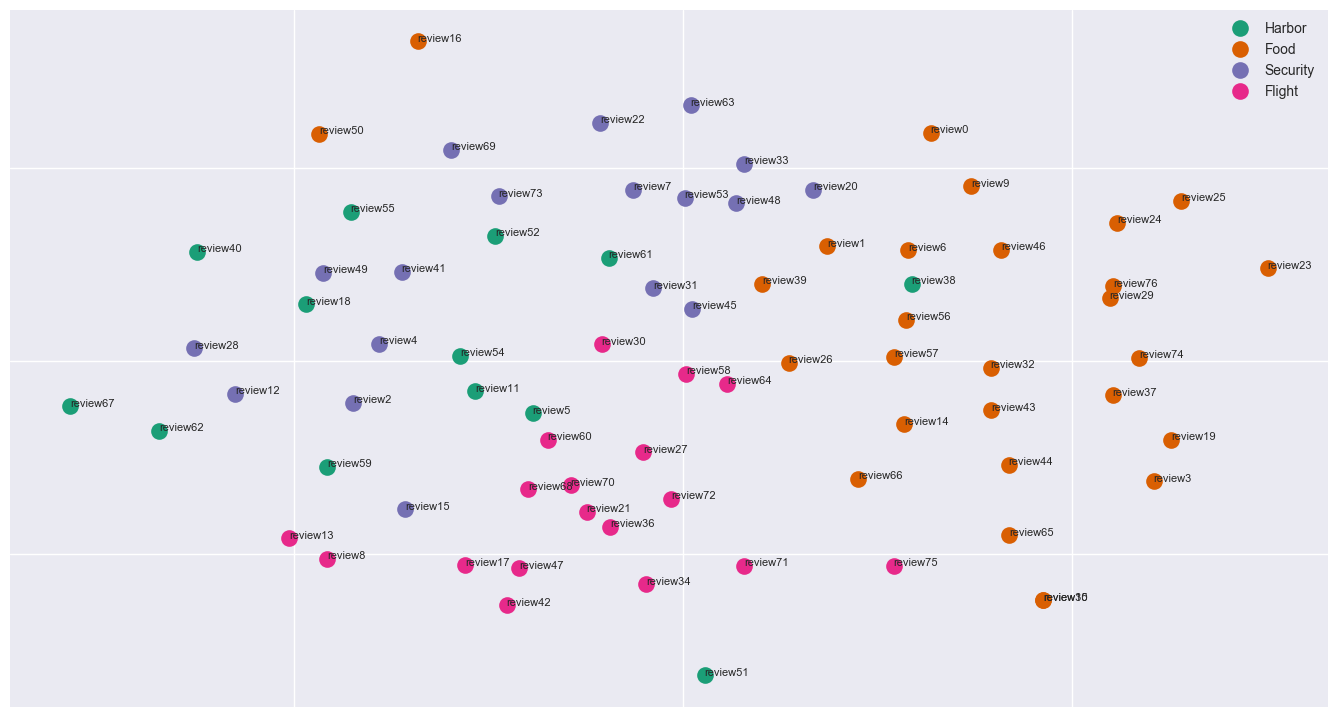

In [143]:
fig, ax = plt.subplots(figsize=(17, 9)) 
ax.margins(0.05)

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',     
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         
        which='both',      
        left='off',      
        top='off',         
        labelleft='off')
    
ax.legend(numpoints=1)  

for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8) 

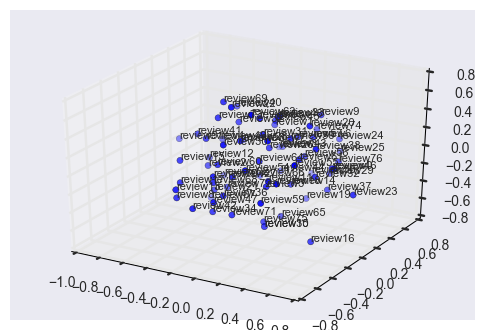

In [144]:
def get_years(labels):
    return [label.split('_')[-1:][0] for label in labels]

mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])

for x, y, z, s in zip(pos[:, 0], pos[:, 1], pos[:, 2], get_years(labels)):
    ax.text(x, y, z, s, size=8)

plt.show()

<h3><center><i> Clustering & Topic Modeling </i></center></h3>

In [145]:
tfidf = TfidfVectorizer(tokenizer=nlp.tokenize_clean_stem).fit_transform(texts.values())

In [146]:
vectors = tfidf.toarray()

In [147]:
dist = pdist(vectors, metric='cosine') 

In [148]:
link = linkage(dist, method="ward")

In [149]:
def make_dend(data, method='ward', labels=None, height=8):
    from pylab import rcParams
    dist = pdist(data, metric='cosine')
    link = linkage(dist, method=method)
    rcParams['figure.figsize'] = 6, height
    rcParams['axes.labelsize'] = 5
    if not labels:
        dend = dendrogram(link, orientation='right') #labels=names)
    else:
        # the label is actually the file + it's number 
        dend = dendrogram(link, orientation='right', labels=[str(i) + '_' + label for i, label in enumerate(labels)])
    return dist

def clean_filenames(paths):
    # Makes labels that are just the root filename minus .txt
    import os
    return [os.path.basename(path).strip(".txt") for path in paths]

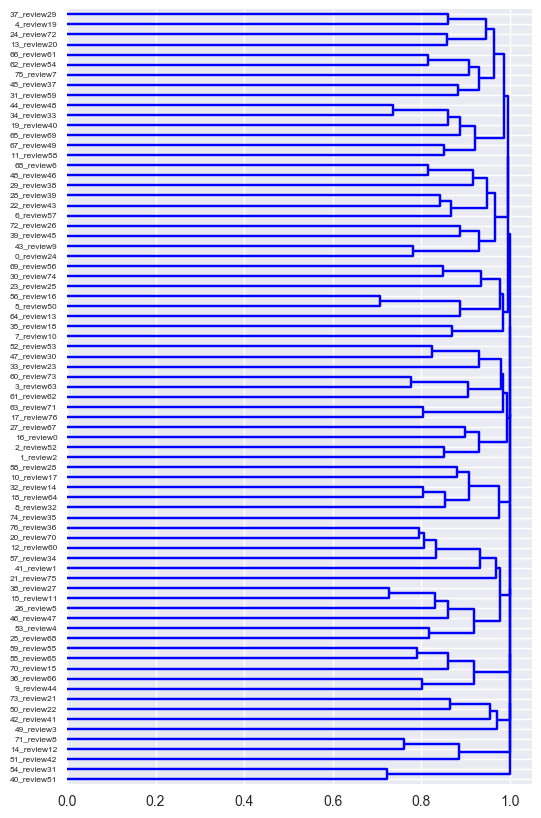

In [150]:
dist = make_dend(vectors, method='complete', height=10, labels=clean_filenames(texts.keys()))

In [151]:
def make_heatmap_matrix(dist, method='complete'):
    """ Pass in the distance matrix; method options are complete or single """
    # Compute and plot first dendrogram.
    fig = plt.figure(figsize=(10,10))
    # x y width height (left, bottom, w, h)
    ax1 = fig.add_axes([0.05,0.1,0.2,0.6])
    Y = linkage(dist, method=method)
    Z1 = dendrogram(Y, orientation='right')
    ax1.set_xticks([])  # suppress labels on height.
    # yticks are the number labels, let them live.

    # Compute and plot second dendrogram.
    ax2 = fig.add_axes([0.3,0.74,0.6,0.2])
    Z2 = dendrogram(Y)
    #ax2.set_xticks([])
    #ax2.set_yticks([])

    #Compute and plot the heatmap
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']
    D = squareform(dist)
    D = D[idx1,:]
    D = D[:,idx2]
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
    plt.colorbar(im, cax=axcolor)

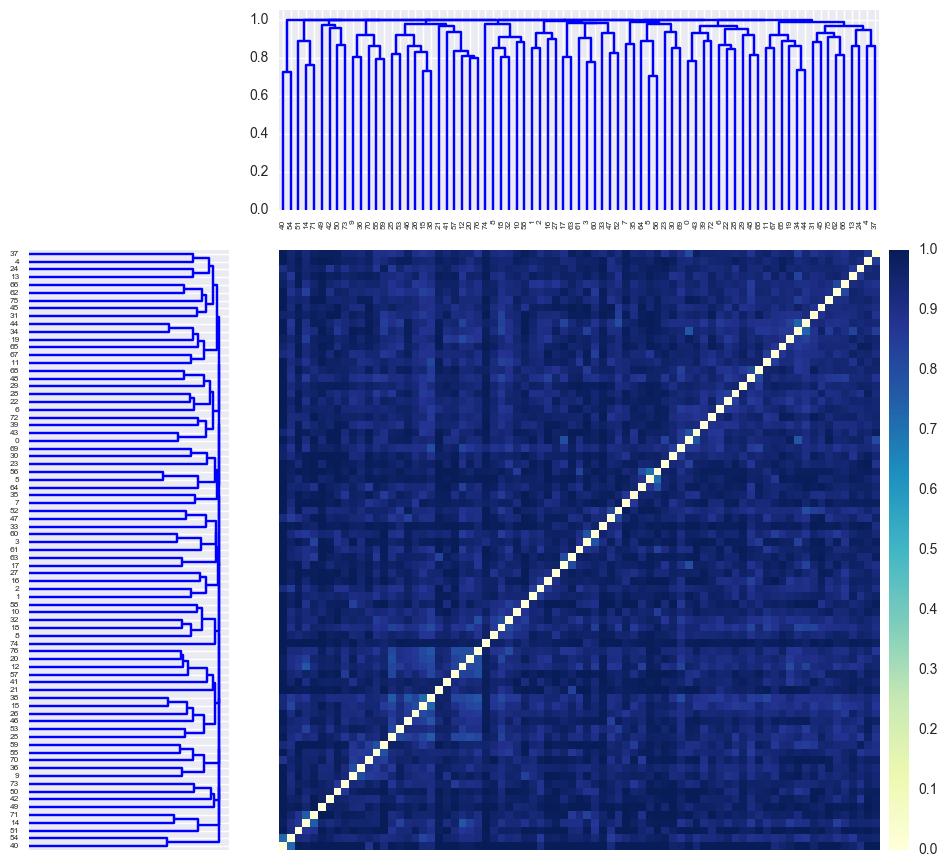

In [152]:
make_heatmap_matrix(dist, method='complete')

<h3><center><i> Sentiment Analysis </i></center></h3>

In [153]:
def get_vader_sentiment(sentence, analyzer):
    """ Pass in the setence to be analysed and the analyzer, e.g., sid.
    Returns a dictionary of the scores.
    """
    ss = analyzer.polarity_scores(sentence)
    return ss

In [154]:
sid = SentimentIntensityAnalyzer()

In [155]:
scores = []

for file in filenames:
    with open(file, encoding="utf8") as handle:
        text = handle.read()
        text = text.strip("\n")
        sentences = nltk.sent_tokenize(text) 
        for i, sent in enumerate(sentences):
            infos = {'Filename':file,'Text':sent,'Index':i}
            myscores = get_vader_sentiment(sent,sid).copy()
            mydict = {k : v for d in [infos, myscores] for k,v in d.items()}
            scores.append(mydict)

In [156]:
Sentiment_Reviews = pd.DataFrame.from_records(scores)

In [157]:
#Most positive reviews
Sentiment_Reviews.sort_values(by ='compound', ascending = False).head()

,Filename,Index,Text,compound,neg,neu,pos
636,data/myreviews/review9.txt,1,"I love it here it's clean, great places to eat...",0.9606,0.000,0.414,0.586
30,data/myreviews/review11.txt,22,The Fox Sports Grill at Sky Harbor is a true e...,0.9587,0.082,0.606,0.312
344,data/myreviews/review52.txt,3,"TSA was cool, the lady at Starbucks was awesom...",0.9245,0.000,0.528,0.472
375,data/myreviews/review54.txt,18,To give those who dislike Sky Harbor the benef...,0.9023,0.078,0.658,0.263
191,data/myreviews/review31.txt,21,"i don't know, but the free wi-fi certainly mad...",0.8955,0.056,0.470,0.474


In [158]:
#Most negative reviews
Sentiment_Reviews.sort_values(by ='compound', ascending = True).head()

,Filename,Index,Text,compound,neg,neu,pos
139,data/myreviews/review27.txt,5,"However, it's the oldest terminal, smells bad ...",-0.8425,0.452,0.548,0.00
91,data/myreviews/review19.txt,9,Yeah I know it sounds crazy but as soon as peo...,-0.8248,0.232,0.728,0.04
562,data/myreviews/review70.txt,1,I had a connecting flight in another terminal ...,-0.8138,0.317,0.683,0.00
148,data/myreviews/review27.txt,14,It's way to difficult to navigate your lanes t...,-0.7724,0.179,0.821,0.00
516,data/myreviews/review64.txt,36,It's not as fabulous as Spokane but... it's al...,-0.7177,0.411,0.589,0.00


In [159]:
NEGWORDS = "data/sentiment_wordlists/negative-words.txt"
POSWORDS = "data/sentiment_wordlists/positive-words.txt"

def load_words(path):
    with open(path, encoding='utf-8', errors='replace') as handle:
        words = handle.readlines()
    words = [w.strip() for w in words if w[0] != ';']
    words = [word for word in words if word]  # get rid of empty string
    return words

negwords = load_words(NEGWORDS)
poswords = load_words(POSWORDS)

In [160]:
def get_overlap(list1, list2):
    """ If you have a list of words (tokens) and you want to get the overlap with a second list, 
    like polarity words.
    Returns the overlapping words and their counts as a tuple.
    """
    from collections import Counter
    list1_multiset = Counter(list1)
    list2_multiset = Counter(list2)
    overlap = list((list1_multiset & list2_multiset).elements())
    totals = []
    for word in overlap:
        totals.append((word, list1_multiset[word]))
    return totals

In [161]:
def get_sentiment_counts(text, filename, poswords=poswords, negwords=negwords):
    """ This takes a text, a filename, and polarity wordlists and counts for you.
    Returns a dictionary.
    """
    from collections import Counter
    count = dict()
    overlap_pos = get_overlap(text, poswords)
    overlap_neg = get_overlap(text, negwords)
    count = {
            "file": filename,
            "positive_total": int(sum(Counter(dict(overlap_pos)).values())),
            "positive_words": list(overlap_pos),
            "negative_total": int(sum(Counter(dict(overlap_neg)).values())),
            "negative_words": list(overlap_neg),
            "word_count": int(len(text)),
            "text": " ".join(text)
        }
    count['net_score'] = count['positive_total'] - count['negative_total']
    return count

In [162]:
myfields = ['file', 'positive_total', 'positive_words', 'negative_total', 'negative_words', 'net_score', 'word_count', 'text']

def write_sentiment_results(output_file, filenames, fields):
    """ Input args are the filename to write to, the files you are analying, and fields to write out. 
    The separator is a tab (\t).
    """
    import csv
    with open(output_file, 'w', errors='ignore') as handle:
        writer = csv.DictWriter(handle, fieldnames=fields, delimiter="\t")
        writer.writeheader()
        for input_file in filenames:
            # here we do exactly what we did above, but for all of them.
            tokens = nlp.tokenize_text(input_file)
            tokens = nlp.clean_tokens(tokens)
            dictversion = get_sentiment_counts(tokens, input_file)
            writer.writerow(dictversion)

In [163]:
write_sentiment_results("reviews_airport.csv", filenames, fields=myfields)

In [164]:
reviews_df = pd.read_csv("reviews_airport.csv", sep="\t")

In [183]:
pos_df = reviews_df.sort_values(by='net_score', ascending = False)

In [188]:
pos_df[['file', 'positive_total', 'negative_total', 'net_score', 'word_count']]

,file,positive_total,negative_total,net_score,word_count
3,data/myreviews/review11.txt,18,8,10,223
62,data/myreviews/review65.txt,11,1,10,42
48,data/myreviews/review52.txt,12,2,10,97
54,data/myreviews/review58.txt,10,1,9,127
30,data/myreviews/review36.txt,11,2,9,238
52,data/myreviews/review56.txt,10,2,8,103
72,data/myreviews/review74.txt,11,3,8,58
25,data/myreviews/review31.txt,13,5,8,135
28,data/myreviews/review34.txt,8,1,7,47
39,data/myreviews/review44.txt,7,0,7,35


In [189]:
neg_df = reviews_df.sort_values(by='net_score', ascending = True)

In [191]:
neg_df[['file', 'positive_total', 'negative_total', 'net_score', 'word_count']]

,file,positive_total,negative_total,net_score,word_count
45,data/myreviews/review5.txt,4,12,-8,134
12,data/myreviews/review2.txt,4,9,-5,120
57,data/myreviews/review60.txt,2,7,-5,120
74,data/myreviews/review76.txt,1,4,-3,34
58,data/myreviews/review61.txt,5,8,-3,108
71,data/myreviews/review73.txt,3,6,-3,120
46,data/myreviews/review50.txt,1,3,-2,11
69,data/myreviews/review71.txt,1,3,-2,25
23,data/myreviews/review3.txt,0,2,-2,6
60,data/myreviews/review63.txt,0,2,-2,14


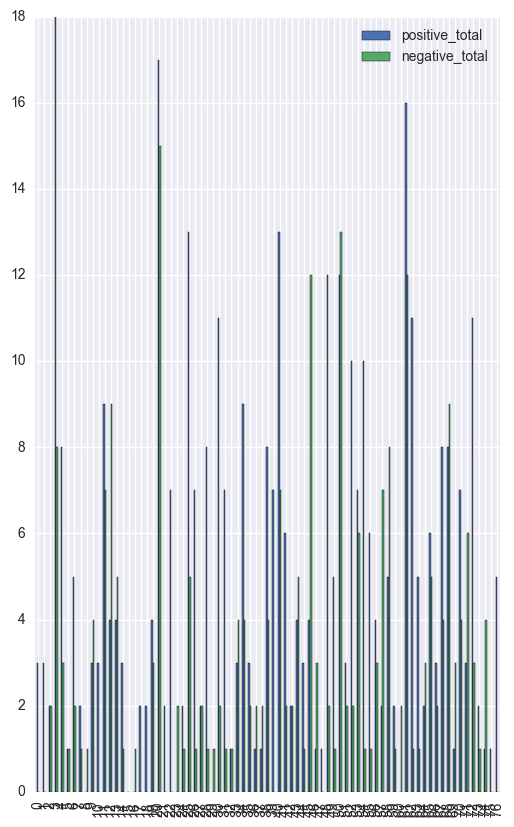

In [166]:
reviews_df[["positive_total", "negative_total"]].plot(kind="bar")

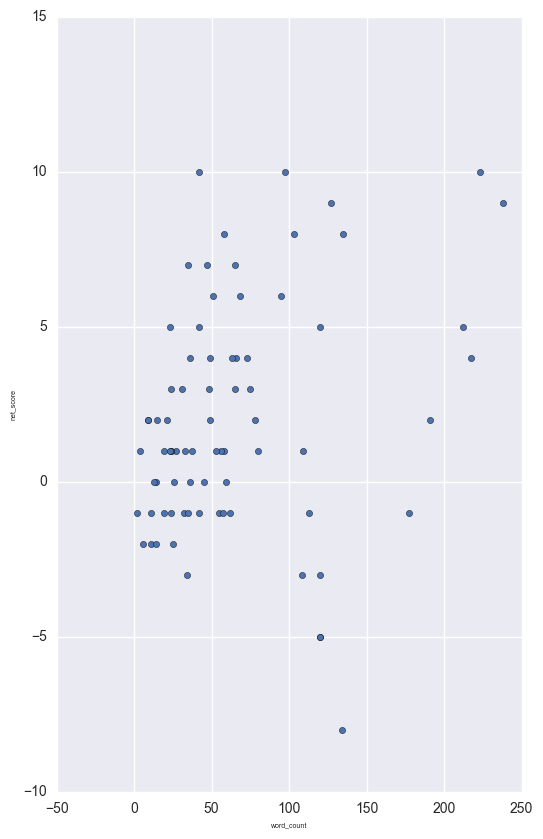

In [178]:
reviews_size = reviews_df.plot(x="word_count", y="net_score", kind="scatter")
plt.savefig('reviews.png')

Long reviews tend to be rather positive than negative such as the shortest ones

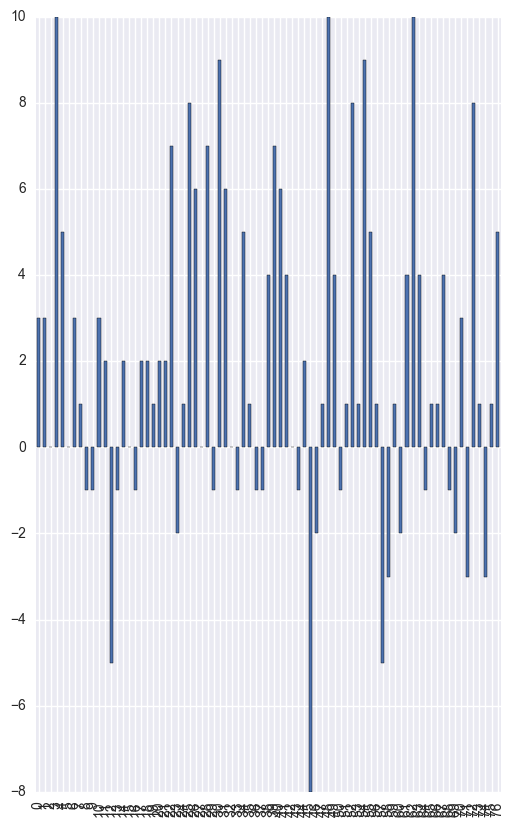

In [168]:
reviews_df['net_score'].plot(kind="bar")